# Invest Soc QF Qn2

### Problem statement

Q2.  Develop a trading strategy/model using an asset (or a combination of assets) from G10 FX, Gold Continuous Futures, Govt Bonds ETF/Futures provided						

### Approach Overview
1. Data Preparation & Exploration
2. Feature Engineering
3. Model Development
4. Walk-Forward Validation
5. Performance Evaluation


In [55]:
# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import mplfinance as mpf
import backtrader as bt

In [56]:
# data 
gold = pd.read_csv('data/Gold.csv', parse_dates=True, index_col=0, date_format='%m/%d/%y')
gold.head()

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-02,15.179778,15.212941,14.848161,14.889613,17503697
2014-01-03,15.047136,15.353883,14.989104,15.279269,13976294
2014-01-06,15.212942,15.387040,15.063714,15.295847,11622763
2014-01-07,15.146621,15.171491,14.881327,15.080297,10216714
2014-01-08,14.889616,15.013974,14.740390,15.013974,13369077


In [57]:
gold.info()
gold.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Open    2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


,Close,High,Low,Open,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,14.885227,15.110079,14.666015,14.896284,1.631677e+07
std,4.309338,4.359555,4.250347,4.317217,7.344741e+06
min,5.041925,5.288080,5.016461,5.160758,0.000000e+00
25%,11.606791,11.762850,11.421661,11.599643,1.113029e+07
50%,14.989721,15.205619,14.782459,15.011905,1.487344e+07
75%,17.324486,17.549096,17.043383,17.316417,1.984837e+07
max,27.110197,27.708836,26.674084,27.691087,6.722794e+07


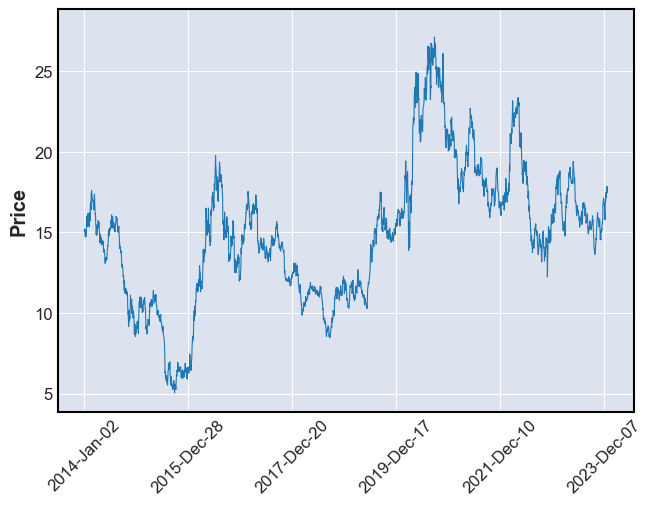

In [58]:
mpf.plot(gold, type='line')

In [59]:
# Return and Target classifier columns
gold['Return'] = gold['Close'].pct_change() # diff between d0 and d-1
gold['Target'] = (gold['Return'].shift(-1) > 0).astype(int) # tells the lm if the stock is going up or down

In [60]:
# Adding technical indicators
def calculate_technical_indicators(df):
    # Moving averages
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()
    df['MA_50'] = df['Close'].rolling(50).mean()

    # RSI
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp12 = df['Close'].ewm(span=12, adjust=False).mean()
    exp26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp12 - exp26
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['Upper_Band'] = df['MA_20'] + (2 * df['Close'].rolling(20).std())
    df['Lower_Band'] = df['MA_20'] - (2 * df['Close'].rolling(20).std())

    # Volume features
    df['Volume_MA_5'] = df['Volume'].rolling(5).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    return df

gold = calculate_technical_indicators(gold)

In [61]:
# removing inf and nan values
np.isinf(gold).sum()
np.isnan(gold).sum()
gold = gold[~np.isinf(gold).any(axis=1) & ~np.isnan(gold).any(axis=1)]

In [64]:
# Model development
features = ['MA_5', 'MA_20', 'MA_50', 'RSI', 'MACD', 'Signal_Line', 
            'Upper_Band', 'Lower_Band', 'Volume_MA_5', 'Volume_Change']
X = gold[features]
y = gold['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # fits the train set into the scaler
X_test_scaled = scaler.transform(X_test) # scales the test set using the train set

rf = RandomForestClassifier(n_estimators=100, random_state=123) # set seed 123
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.42      0.47       386
           1       0.48      0.57      0.52       354

    accuracy                           0.49       740
   macro avg       0.50      0.50      0.49       740
weighted avg       0.50      0.49      0.49       740



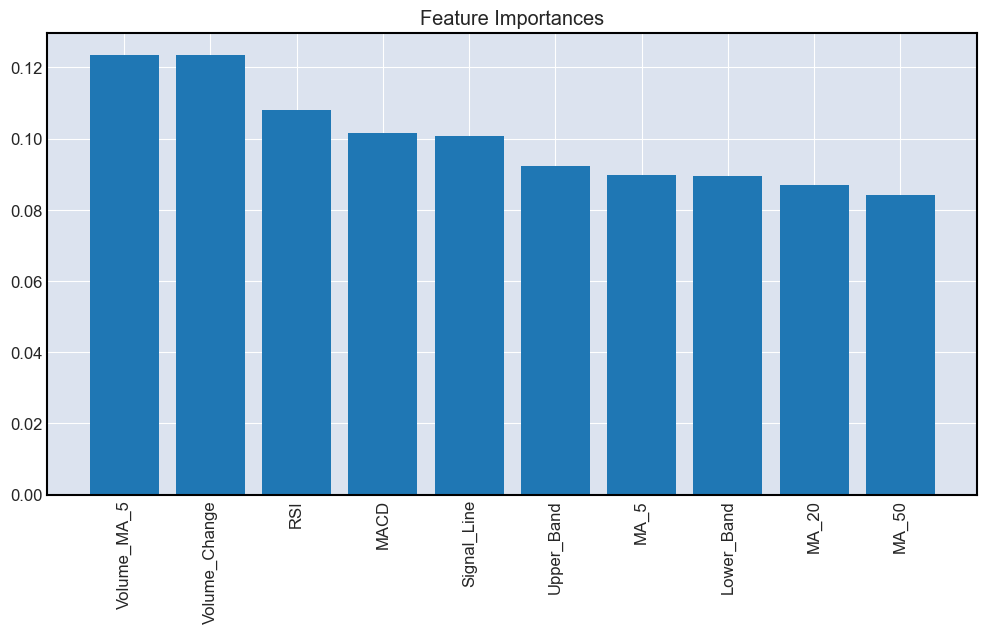

In [65]:
# Visualising variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title('Feature Importances')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
plt.show()

In [75]:
# Walk forward Validation
def walk_forward_validation(data, features, train_size=252, test_size=63):
    predictions = []
    actuals = []
    
    n_splits = (len(data) - train_size) // test_size
    
    for i in range(n_splits):
        # Split data
        train_start = i * test_size
        train_end = train_start + train_size
        test_end = train_end + test_size
        
        train_data = data.iloc[train_start:train_end]
        test_data = data.iloc[train_end:test_end]
        
        # Prepare features and target
        X_train = train_data[features]
        y_train = train_data['Target']
        X_test = test_data[features]
        y_test = test_data['Target']
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Predict and store results
        y_pred = model.predict(X_test_scaled)
        predictions.extend(y_pred)
        actuals.extend(y_test.values)
    
    return np.array(predictions), np.array(actuals)

optimised_features = ['Volume_MA_5', 'Volume_Change']

predictions, actuals = walk_forward_validation(gold, optimised_features)

print(classification_report(actuals, predictions))
print(confusion_matrix(actuals, predictions))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1104
           1       0.50      0.47      0.48      1101

    accuracy                           0.50      2205
   macro avg       0.50      0.50      0.50      2205
weighted avg       0.50      0.50      0.50      2205

[[591 513]
 [585 516]]


In [76]:
predictions

array([1, 1, 0, ..., 1, 1, 0], shape=(2205,))